In [1]:
import numpy as np
import pandas as pd

import skimage
import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

import os
import shutil

from math import sqrt
from numpy import dot
from numpy.linalg import norm

In [2]:
# Число изображений на каждом объекте
N = 1000
# Размер изображения
img_size = 256
# Глубина рекурсии функции бинарного метода Хаара
# Размер вектор-признака равна 2**max_depth - 1 по построению функции
max_depth = 13

# Название объекта изображения
imgs_name_1 = "airplane"
imgs_name_2 = "cars"

# Используемые методы в CBIR системе
numpy2vec_method = "diag"
dec2bin_method = "Harr"
distance_method = "norm_hamming"

In [4]:
def rename_imgs(file_path):
    file_names = os.listdir(file_path)
    i = 0
    for name in file_names:
        src = os.path.join(file_path, name)
        dst = str(i) + ".jpg"
        dst = os.path.join(file_path, dst)
        if not os.path.isfile(dst):
            os.rename(src, dst) 
        i += 1
    
    return "Done"

def jpg2numpy(file_path):
    img = skimage.io.imread(file_path)
    resized_img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    return np.array(resized_img)

def save_imgs(file_path, matrix):
    count_of_imgs = len(matrix)
    for i in range(0, count_of_imgs):
        skimage.io.imsave(file_path + "\\%d.jpg"%(i), matrix[i])
    return "Done"

def shuffle_imgs(matrix):
    return np.random.shuffle(matrix)

A = np.array([1, 2, 3])
print("Shuffle before:", A)
shuffle_imgs(A)
print("\t after:", A)
    
def test_search_split(matrix, test_size=0.3, shuffle=True):
    matrix_ = matrix.copy()
    if shuffle:
        shuffle_imgs(matrix_)
    size_of_matrix = len(matrix_)
    threshold = round(size_of_matrix * test_size)
    return matrix_[:threshold], matrix_[threshold:]

A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B, C = test_search_split(A, shuffle=False)
np.testing.assert_array_equal(B, np.array([[1, 2, 3]]))
np.testing.assert_array_equal(C, np.array([[4, 5, 6], [7, 8, 9]]))
assert len(B) + len(C) == len(A)

Shuffle before: [1 2 3]
	 after: [1 3 2]


In [5]:
file_path_1 = "data_\\%s"%(imgs_name_1)
file_path_2 = "data_\\%s"%(imgs_name_2)
rename_imgs(file_path_1)
rename_imgs(file_path_2)

'Done'

In [6]:
start_time = time.time()

imgs_1, imgs_2 = [], []

for i in range(N):
    file_path = "data_\\%s\\%d.jpg"%(imgs_name_1, i)
    imgs_1.append(jpg2numpy(file_path))
    
    file_path = "data_\\%s\\%d.jpg"%(imgs_name_2, i)
    imgs_2.append(jpg2numpy(file_path))

imgs_1 = np.array(imgs_1)
imgs_2 = np.array(imgs_2)

imgs = np.concatenate((imgs_1, imgs_2))

assert imgs_1.shape == (N, img_size, img_size, 3)
assert imgs_2.shape == (N, img_size, img_size, 3)
assert imgs.shape == (2 * N, img_size, img_size, 3)

print("--- %s seconds ---" % (time.time() - start_time))

--- 56.9117910861969 seconds ---


In [7]:
# создание тестового, поискового файла
test_file_path= "data_\\test_dataset"
search_file_path = "data_\\search_dataset"
test_imgs, search_imgs = test_search_split(imgs, shuffle=True)
save_imgs(test_file_path, test_imgs)
save_imgs(search_file_path, search_imgs)

'Done'

In [8]:
imgs_dict = {imgs_name_1:imgs_1, imgs_name_2:imgs_2}
imgs_tuple = []
i = 0
for k, v in imgs_dict.items():
    for words in v:
        imgs_tuple.append((i, k, words))
        i += 1
        
test_imgs_tuple, search_imgs_tuple = test_search_split(imgs_tuple, shuffle=True)

In [9]:
#Преобразование RGB в серый цвет
def RGB2GRAY(img):
    return 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

In [10]:
imgs_gray_tuple = []
for i in range(len(imgs_tuple)):
    imgs_gray_tuple.append((imgs_tuple[i][0], imgs_tuple[i][1], RGB2GRAY(imgs_tuple[i][2])))

In [11]:
#создание tuple для поискового датасета
start_time = time.time()
search_N = len(search_imgs)
search_imgs_gray = []

for i in range(search_N):
    search_imgs_gray.append((search_imgs_tuple[i][0], search_imgs_tuple[i][1], RGB2GRAY(search_imgs_tuple[i][2])))

#создание tuple для тестового датасета
test_N = len(test_imgs)
test_imgs_gray = []
for i in range(test_N):
    test_imgs_gray.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1], RGB2GRAY(test_imgs_tuple[i][2])))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8235845565795898 seconds ---


In [12]:
def diag_trans(vec):
    N = vec.shape[0]
    M = vec.shape[1]
    diagonals = []
    for i in range(-(N - 1), M):
        for j in range(N):
            row, col = j, i + j
            if (0 <= row < vec.shape[0]) and (0 <= col < vec.shape[1]):
                diagonals.append(vec[row][col])
    return diagonals

def diag_trans(matrix):
    matrix = np.array(matrix)
    array = []
    r = matrix.shape[0]
    for i in range(-r+1,r):
        array = np.concatenate((array,np.diag(matrix,i)),axis=None)
    return array

def numpy2vec(img_g, method="row"):
    img_g = np.array(img_g)
    if (method == "row"):
        #Развертывание матрицы в вектор постолбцово
        return img_g.reshape(-1)
    elif (method == "col"):
        return img_g.T.reshape(-1)
    elif (method == "diag"):
        #Развертывание матрицы в вектор лесенка
        return diag_trans(img_g)
    return 0

display(np.array([[1,2,3],[4,5,6],[7,8,9]]))
print("row:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="row"), "\n")
print("col:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="col"), "\n")
print("diag:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="diag"), "\n")

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

row: [1 2 3 4 5 6 7 8 9] 

col: [1 4 7 2 5 8 3 6 9] 

diag: [7. 4. 8. 1. 5. 9. 2. 6. 3.] 



In [13]:
#для поискового датасета
start_time = time.time()
search_N = len(search_imgs)
search_imgs_vec = []
numpy2vec_method = "diag"

for i in range(search_N):
    search_imgs_vec.append((search_imgs_gray[i][0], search_imgs_gray[i][1],
                            numpy2vec(search_imgs_gray[i][2], method=numpy2vec_method)))

#для тестового датасета
test_N = len(test_imgs)
test_imgs_vec = []

for i in range(test_N):
    test_imgs_vec.append((test_imgs_gray[i][0], test_imgs_gray[i][1],
                          numpy2vec(test_imgs_gray[i][2], method=numpy2vec_method)))

print("--- %s seconds ---" % (time.time() - start_time))

--- 16.402440309524536 seconds ---


In [14]:
#binary_array with Harr
def dec2bin_Harr(vec=[], current_depth=1, max_depth=max_depth):
    size = len(vec)
    if size == 1:
        return [0]
    elif size == 2:
        return [1] if vec[0] > vec[1] else [0]
    elif current_depth > max_depth:
        return []
    else:
        median_index = size // 2
        left_sum, right_sum = sum(vec[:median_index]), sum(vec[median_index:])
        if left_sum > right_sum:
            return dec2bin_Harr(vec[:median_index], current_depth + 1, max_depth) + [1] + dec2bin_Harr(vec[median_index:], current_depth + 1, max_depth)
        else:
            return dec2bin_Harr(vec[:median_index], current_depth + 1, max_depth) + [0] + dec2bin_Harr(vec[median_index:], current_depth + 1, max_depth)
        
a = [1, 2, 3, 4]
assert dec2bin_Harr(a) == [0, 0, 0]

In [15]:
#binary_array with median
def dec2bin(vec, method="mean", max_depth=max_depth):
    if (method == "mean"):
        med = np.median(vec)
        binary_array = [int(x >= med) for x in vec]
        return binary_array
    elif (method == "Harr"):
        return dec2bin_Harr(vec, max_depth=max_depth)
    
a = [1, 2, 3, 4, 3, 2, 1]
#sorted_a: 1 1 2 2 3 3 4
assert dec2bin(a, "mean") == [0, 1, 1, 1, 1, 1, 0]

In [16]:
#для поискового датасета
start_time = time.time()
search_N = len(search_imgs)
search_imgs_bin = []

for i in range(search_N):
    search_imgs_bin.append((search_imgs_vec[i][0], search_imgs_vec[i][1],
                            dec2bin(search_imgs_vec[i][2], method=dec2bin_method)))

#для тестового датасета
test_N = len(test_imgs)
test_imgs_bin = []

for i in range(test_N):
    test_imgs_bin.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1],
                          dec2bin(test_imgs_vec[i][2], method=dec2bin_method)))

print("--- %s seconds ---" % (time.time() - start_time))

--- 147.71651768684387 seconds ---


In [17]:
search_imgs_bin_number = []
search_imgs_bin_name = []
search_imgs_bin_ = []
for search_img_bin in search_imgs_bin:
    search_imgs_bin_number.append(search_img_bin[0])
    search_imgs_bin_name.append(search_img_bin[1])
    search_imgs_bin_.append(search_img_bin[2])

In [18]:
df_search_imgs = pd.DataFrame({"number":search_imgs_bin_number, "class":search_imgs_bin_name, "bin":search_imgs_bin_})
df_search_imgs.to_csv("data_//search_imgs.csv", sep='\t', index=False)

In [19]:
def my_hamming_distance(bin1, bin2):
    dist = 0
    for n in range(len(bin1)):
        if bin1[n] != bin2[n]:
            dist += 1
    
    return dist

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert my_hamming_distance(a, b) == 2

def my_cos_distance(bin1, bin2):
    count_one, sum_bin1, sum_bin2 = 0, 0, 0
    for i in range(len(bin1)):
        count_one += bin1[i] * bin2[i]
        sum_bin1 += bin1[i] #bin1[i]**2
        sum_bin2 += bin2[i] #bin2[i]**2
    return 1 - count_one / (sqrt(sum_bin1) * sqrt(sum_bin2))

a, b = [1, 1, 0, 0], [1, 0, 0, 0] 
assert my_cos_distance(a, b) == 0.29289321881345254

def my_euclid_distance(bin1, bin2):
    dist = 0
    for i in range(len(bin1)):
        dist += (bin1[i] - bin2[i]) ** 2
    return sqrt(dist)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert my_euclid_distance(a, b) == 1.4142135623730951

def hamming_distance(bin1, bin2):
    bin1 = np.array(bin1)
    bin2 = np.array(bin2)
    return np.count_nonzero(bin1 != bin2)


def hamming_distance(bin1, bin2):
    x = np.array(bin1)
    y = np.array(bin2)  
    return np.sum(x != y)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert hamming_distance(a, b) == 2
assert hamming_distance(a, b) == my_hamming_distance(a, b)

def cos_distance(bin1, bin2):
    return 1 - dot(bin1, bin2) / (norm(bin1) * norm(bin2))

a, b = [1, 1, 0, 0], [1, 0, 0, 0] 
assert cos_distance(a, b) == 0.29289321881345254
assert cos_distance(a, b) == my_cos_distance(a, b)

def euclid_distance(bin1, bin2):
    bin1 = np.array(bin1)
    bin2 = np.array(bin2)
    return norm(bin1 - bin2)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert euclid_distance(a, b) == 1.4142135623730951
assert euclid_distance(a, b) == my_euclid_distance(a, b)

def norm_hamming_distance(bin1, bin2):
    return hamming_distance(bin1, bin2) / len(bin1)

def my_norm_hamming_distance(bin1, bin2):
    return my_hamming_distance(bin1, bin2) / len(bin1)

def norm_euclid_distance(bin1, bin2):
    return euclid_distance(bin1, bin2) / len(bin1)

def distance(bin1, bin2, method="hamming"):
    if method == "my_hamming":
        return my_hamming_distance(bin1, bin2)
    elif method == "my_cos":
        return my_cos_distance(bin1, bin2)
    elif method == "my_euclid":
        return my_euclid_distance(bin1, bin2)
    elif method == "hamming":
        return hamming_distance(bin1, bin2)
    elif method == "cos":
        return cos_distance(bin1, bin2)
    elif method == "euclid":
        return euclid_distance(bin1, bin2)
    elif method == "norm_hamming":
        return norm_hamming_distance(bin1, bin2)
    elif method == "norm_euclid":
        return norm_euclid_distance(bin1, bin2)
    elif method == "my_norm_hamming":
        return my_norm_hamming_distance(bin1, bin2)

def show_heatmap(table):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(table, ax=ax)


In [20]:
start_time = time.time()
#номер, класс т, номер, класс п, расстояние по Хэмминге
hamming_distance_matrix = []
#distance_method="my_norm_hamming"
for i in range(test_N):
    hamming_distance_list = []
    for j in range(search_N):
        hamming_distance_list.append((test_imgs_bin[i][0], test_imgs_bin[i][1],
                                      search_imgs_bin[j][0], search_imgs_bin[j][1],
                                      distance(test_imgs_bin[i][2], search_imgs_bin[j][2], method=distance_method)))
    hamming_distance_matrix.append(hamming_distance_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 290.5979335308075 seconds ---


In [21]:
pd.DataFrame(hamming_distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,"(925, airplane, 452, airplane, 0.5608207132388...","(925, airplane, 1, airplane, 0.6355642403517342)","(925, airplane, 1052, cars, 0.3038593063019052)","(925, airplane, 793, airplane, 0.4855886663409...","(925, airplane, 1613, cars, 0.4235466536394724)","(925, airplane, 1520, cars, 0.37567171470444555)","(925, airplane, 1272, cars, 0.5803615046409379)","(925, airplane, 1696, cars, 0.5393258426966292)","(925, airplane, 1645, cars, 0.3126526624328285)","(925, airplane, 864, airplane, 0.5759648265754...",...,"(925, airplane, 321, airplane, 0.5100146555935...","(925, airplane, 1690, cars, 0.5266243282852956)","(925, airplane, 356, airplane, 0.2896922325354...","(925, airplane, 1647, cars, 0.5153883732291158)","(925, airplane, 1490, cars, 0.4596971177332682)","(925, airplane, 1590, cars, 0.4142647777234978)","(925, airplane, 1912, cars, 0.37420615534929164)","(925, airplane, 876, airplane, 0.3390327308255...","(925, airplane, 1865, cars, 0.407914020517831)","(925, airplane, 1677, cars, 0.33952125061064975)"
1,"(1742, cars, 452, airplane, 0.3981436248168051)","(1742, cars, 1, airplane, 0.48851978505129456)","(1742, cars, 1052, cars, 0.5144113336590131)","(1742, cars, 793, airplane, 0.666829506595017)","(1742, cars, 1613, cars, 0.3488031265266243)","(1742, cars, 1520, cars, 0.466047874938935)","(1742, cars, 1272, cars, 0.41279921836834393)","(1742, cars, 1696, cars, 0.5095261358085003)","(1742, cars, 1645, cars, 0.4509037616023449)","(1742, cars, 864, airplane, 0.4650708353688324)",...,"(1742, cars, 321, airplane, 0.6765999022960429)","(1742, cars, 1690, cars, 0.5056179775280899)","(1742, cars, 356, airplane, 0.39863214460185636)","(1742, cars, 1647, cars, 0.6243282852955545)","(1742, cars, 1490, cars, 0.38006839276990717)","(1742, cars, 1590, cars, 0.43038593063019054)","(1742, cars, 1912, cars, 0.524181729360039)","(1742, cars, 876, airplane, 0.583781143136297)","(1742, cars, 1865, cars, 0.40840254030288226)","(1742, cars, 1677, cars, 0.49145090376160233)"
2,"(651, airplane, 452, airplane, 0.5192965315095...","(651, airplane, 1, airplane, 0.5461651196873474)","(651, airplane, 1052, cars, 0.4596971177332682)","(651, airplane, 793, airplane, 0.7000488519785...","(651, airplane, 1613, cars, 0.5500732779677577)","(651, airplane, 1520, cars, 0.537371763556424)","(651, airplane, 1272, cars, 0.353199804592086)","(651, airplane, 1696, cars, 0.4987787005373718)","(651, airplane, 1645, cars, 0.5007327796775769)","(651, airplane, 864, airplane, 0.5021983390327...",...,"(651, airplane, 321, airplane, 0.6609672691744...","(651, airplane, 1690, cars, 0.5749877870053737)","(651, airplane, 356, airplane, 0.4982901807523...","(651, airplane, 1647, cars, 0.6311675622862726)","(651, airplane, 1490, cars, 0.4240351734245237)","(651, airplane, 1590, cars, 0.3277967757694187)","(651, airplane, 1912, cars, 0.6541279921836834)","(651, airplane, 876, airplane, 0.7225207620908...","(651, airplane, 1865, cars, 0.5735222276502199)","(651, airplane, 1677, cars, 0.5578895945285784)"
3,"(1731, cars, 452, airplane, 0.48851978505129456)","(1731, cars, 1, airplane, 0.45481191988275527)","(1731, cars, 1052, cars, 0.592085979482169)","(1731, cars, 793, airplane, 0.31069858329262334)","(1731, cars, 1613, cars, 0.4352711284807035)","(1731, cars, 1520, cars, 0.4606741573033708)","(1731, cars, 1272, cars, 0.6223742061553493)","(1731, cars, 1696, cars, 0.449438202247191)","(1731, cars, 1645, cars, 0.4601856375183195)","(1731, cars, 864, airplane, 0.48510014655593553)",...,"(1731, cars, 321, airplane, 0.378114313629702)","(1731, cars, 1690, cars, 0.38202247191011235)","(1731, cars, 356, airplane, 0.4968246213971666)","(1731, cars, 1647, cars, 0.3541768441621886)","(1731, cars, 1490, cars, 0.46458231558378116)","(1731, cars, 1590, cars, 0.6614557889594529)","(1731, cars, 1912, cars, 0.2716170004885198)","(1731, cars, 876, airplane, 0.3302393746946751)","(1731, cars, 1865, cars, 0.40302882266731804

In [22]:
def sort_distance(distance_matrix):
    res = []
    n = len(distance_matrix)
    for i in range(n):
        a = sorted(distance_matrix[i], key=lambda x: x[4])
        res.append(a)
    
    return res

In [23]:
start_time = time.time()
sorted_h_distance = sort_distance(hamming_distance_matrix)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3027627468109131 seconds ---


In [24]:
def class_by_matrix(info):
    if info[1] != info[3]:
        return 0
    else:
        return 1

In [25]:
def bad_color(val):
    result = 'black'
    if (not val):
        result = 'red'
    return (result)

In [26]:
def pretty_axis(plt, ax):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()
    plt.tick_params(
        left=False,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False
    ) # labels along the bottom edge are off

In [27]:
sorted_h_distance[0][0]

(925, 'airplane', 906, 'airplane', 0.13776257938446507)

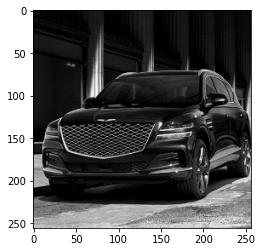

In [28]:
plt.imshow(imgs_tuple[1050][2])

In [29]:
def show_i_nearest_img(i, j, r, k):
    nearest_img_info = sorted_distance[i][j]
    search_index, search_name = nearest_img_info[2], nearest_img_info[3]
    # рисуем изображение поисковой выборки
    ax = fig.add_subplot(4, r, k + r + j * r)
    plt.imshow(imgs_gray_tuple[search_index][2], cmap='gray')
    pretty_axis(plt, ax)
    
    # проверка на совпадение классов
    if (not class_by_matrix(nearest_img_info)):
        plt.title(search_name, color=bad_color(class_by_matrix(nearest_img_info)))
        return 1
    else:
        plt.title(search_name, color=bad_color(class_by_matrix(nearest_img_info)))

    return 0

8


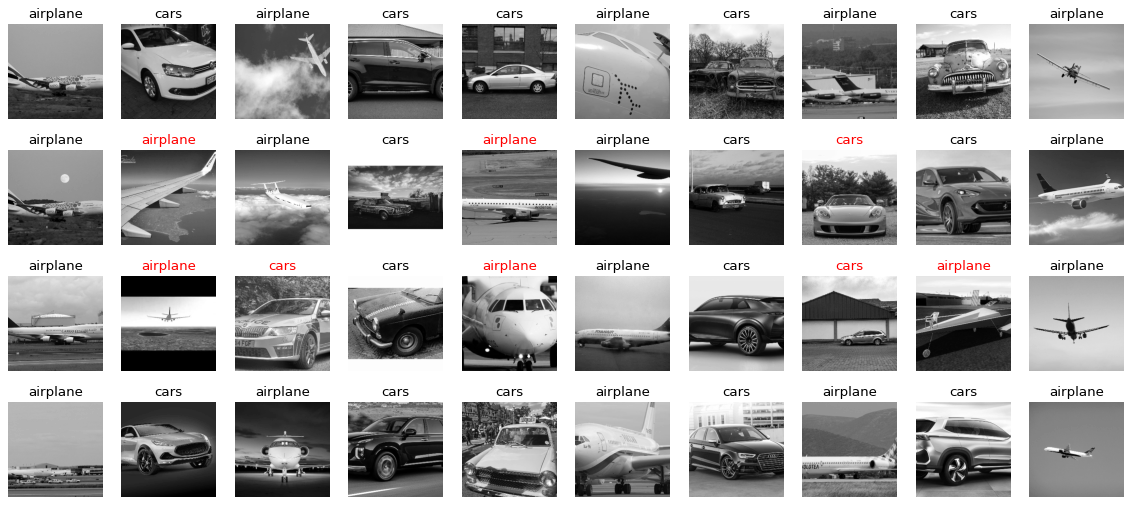

In [30]:
fig = plt.figure(figsize=(18, 8), dpi=80)

sorted_distance = sorted_h_distance

k = 1
r = 10
count_false = 0
for i in range(r):
    ax = fig.add_subplot(4, r, k)
    nearest_img_info = sorted_distance[i][0] # так как new_order[0] - это индекс самого изображения к которому ищем ближайшее
    test_index, test_name = nearest_img_info[0], nearest_img_info[1]
    # рисуем изображение тестовой выборки
    plt.imshow(imgs_gray_tuple[test_index][2], cmap='gray')
    pretty_axis(plt, ax)
    plt.title(test_name)
    
    count_false += show_i_nearest_img(i, 0, r, k)
    count_false += show_i_nearest_img(i, 1, r, k)
    count_false += show_i_nearest_img(i, 2, r, k)

    k = k + 1

print(count_false)

In [31]:
30 / 40

0.75

In [32]:
sorted_distance = sorted_h_distance

r = 600
count_false = 0
for i in range(r):
    nearest_img_info = sorted_distance[i][0] # так как new_order[0] - это индекс самого изображения к которому ищем ближайшее
    test_index, search_index = nearest_img_info[0], nearest_img_info[2]
    test_name, search_name = nearest_img_info[1], nearest_img_info[3]
    
    # проверка на совпадение классов
    if (not class_by_matrix(nearest_img_info)):
        count_false += 1

print("accuracy:", 1 - count_false / r)

accuracy: 0.7133333333333334


In [33]:
# Cоздадим файл ближайших изображений
df_sorted_dist_3 = pd.DataFrame(sorted_distance).loc[:, 0:3]
df_sorted_dist_3.to_csv("data_//sorted_dist.csv", sep='\t', index=False)

In [34]:
df_sorted_dist_3

,0,1,2,3
0,"(925, airplane, 906, airplane, 0.1377625793844...","(925, airplane, 507, airplane, 0.2134831460674...","(925, airplane, 746, airplane, 0.2173913043478...","(925, airplane, 567, airplane, 0.2183683439179..."
1,"(1742, cars, 280, airplane, 0.2784562774792379)","(1742, cars, 479, airplane, 0.28138739618954567)","(1742, cars, 1041, cars, 0.2916463116756229)","(1742, cars, 1159, cars, 0.2916463116756229)"
2,"(651, airplane, 56, airplane, 0.24474841231069...","(651, airplane, 1519, cars, 0.2530532486565706)","(651, airplane, 301, airplane, 0.2535417684416...","(651, airplane, 607, airplane, 0.2550073277967..."
3,"(1731, cars, 1547, cars, 0.2076209086468002)","(1731, cars, 1715, cars, 0.22276502198339032)","(1731, cars, 1914, cars, 0.23546653639472398)","(1731, cars, 921, airplane, 0.24621397166585246)"
4,"(1076, cars, 984, airplane, 0.2994626282364436)","(1076, cars, 674, airplane, 0.32291157791890573)","(1076, cars, 1465, cars, 0.32730825598436736)","(1076, cars, 1101, cars, 0.33170493404982904)"
...,...,...,...,...
595,"(982, airplane, 574, airplane, 0.197361993160723)","(982, airplane, 932, airplane, 0.2051783097215...","(982, airplane, 569, airplane, 0.2169027845627...","(982, airplane, 507, airplane, 0.2188568637029..."
596,"(1346, cars, 719, airplane, 0.3077674645823156)","(1346, cars, 151, airplane, 0.31216414264777725)","(1346, cars, 393, airplane, 0.32633121641426477)","(1346, cars, 1494, cars, 0.3277967757694187)"
597,"(1295, cars, 1846, cars, 0.26917440156326333)","(1295, cars, 1175, cars, 0.28334147532975085)","(1295, cars, 1507, cars, 0.298485588666341)","(1295, cars, 1003, cars, 0.3038593063019052)"
598,"(1993, cars, 1304, cars, 0.19247679531021006)","(1993, cars, 362, airplane, 0.2071323888617489)","(1993, cars, 1036, cars, 0.21348314606741572)","(1993, cars, 1138, cars, 0.2164142647777235)"


In [37]:
graph = []
n = 600
m = 1400
for i in range(n):
    one_line = []
    for j in range(m):
        one_line.append(class_by_matrix(sorted_distance[i][j]))
    graph.append(one_line)

In [40]:
pd.DataFrame(sorted_distance)

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,"(925, airplane, 906, airplane, 0.1377625793844...","(925, airplane, 507, airplane, 0.2134831460674...","(925, airplane, 746, airplane, 0.2173913043478...","(925, airplane, 567, airplane, 0.2183683439179...","(925, airplane, 569, airplane, 0.2203224230581...","(925, airplane, 474, airplane, 0.2252076209086...","(925, airplane, 574, airplane, 0.2252076209086...","(925, airplane, 65, airplane, 0.22667318026380...","(925, airplane, 484, airplane, 0.2300928187591...","(925, airplane, 91, airplane, 0.23155837811431...",...,"(925, airplane, 1142, cars, 0.7186126038104543)","(925, airplane, 669, airplane, 0.723009281875916)","(925, airplane, 361, airplane, 0.7239863214460...","(925, airplane, 151, airplane, 0.7293600390815...","(925, airplane, 1606, cars, 0.7318026380068393)","(925, airplane, 645, airplane, 0.7342452369320...","(925, airplane, 406, airplane, 0.734733756717147)","(925, airplane, 999, airplane, 0.7376648754274...","(925, airplane, 109, airplane, 0.7391304347826...","(925, airplane, 928, airplane, 0.7630679042501..."
1,"(1742, cars, 280, airplane, 0.2784562774792379)","(1742, cars, 479, airplane, 0.28138739618954567)","(1742, cars, 1041, cars, 0.2916463116756229)","(1742, cars, 1159, cars, 0.2916463116756229)","(1742, cars, 1676, cars, 0.29555446995603324)","(1742, cars, 143, airplane, 0.2960429897410845)","(1742, cars, 1132, cars, 0.3004396678065462)","(1742, cars, 1955, cars, 0.30288226673180263)","(1742, cars, 1191, cars, 0.30288226673180263)","(1742, cars, 1162, cars, 0.3048363458720078)",...,"(1742, cars, 1545, cars, 0.6585246702491451)","(1742, cars, 1502, cars, 0.6609672691744015)","(1742, cars, 1778, cars, 0.6614557889594529)","(1742, cars, 259, airplane, 0.6624328285295554)","(1742, cars, 1717, cars, 0.6638983878847093)","(1742, cars, 912, airplane, 0.6643869076697606)","(1742, cars, 793, airplane, 0.666829506595017)","(1742, cars, 321, airplane, 0.6765999022960429)","(1742, cars, 598, airplane, 0.6780654616511969)","(1742, cars, 2, airplane, 0.6976062530532486)"
2,"(651, airplane, 56, airplane, 0.24474841231069...","(651, airplane, 1519, cars, 0.2530532486565706)","(651, airplane, 301, airplane, 0.2535417684416...","(651, airplane, 607, airplane, 0.2550073277967...","(651, airplane, 828, airplane, 0.2550073277967...","(651, airplane, 1515, cars, 0.2564728871519297)","(651, airplane, 1893, cars, 0.26380068392769906)","(651, airplane, 1170, cars, 0.26917440156326333)","(651, airplane, 1147, cars, 0.2730825598436737)","(651, airplane, 1832, cars, 0.27357107962872496)",...,"(651, airplane, 135, airplane, 0.7508549096238...","(651, airplane, 15, airplane, 0.7523204689789936)","(651, airplane, 596, airplane, 0.7591597459697...","(651, airplane, 797, airplane, 0.7684416218856...","(651, airplane, 1443, cars, 0.7684416218856863)","(651, airplane, 1799, cars, 0.7689301416707377)","(651, airplane, 518, airplane, 0.7752808988764...","(651, airplane, 1704, cars, 0.7787005373717636)","(651, airplane, 1906, cars, 0.7821201758671226)","(651, airplane, 859, airplane, 0.7830972154372..."
3,"(1731, cars, 1547, cars, 0.2076209086468002)","(1731, cars, 1715, cars, 0.22276502198339032)","(1731, cars, 1914, cars, 0.23546653639472398)","(1731, cars, 921, airplane, 0.24621397166585246)","(1731, cars, 1324, cars, 0.24963361016121152)","(1731, cars, 1704, cars, 0.24963361016121152)","(1731, cars, 1290, cars, 0.24963361016121152)","(1731, cars, 1906, cars, 0.2510991695163654)","(1731, cars, 1482, cars, 0.25158768930141673)","(1731, cars, 440, airplane, 0.25500732779677576)",...,"(1731, cars, 837, airplane, 0.714704445530044)","(1731, cars, 828, airplane, 0.7186126038104543)","(1731, cars, 435, airplane, 0.7239863214460186)","(1731, cars, 1641, cars, 0.7327796775769418)","(1731, cars, 56, airplane, 0.7337567171470445)","(1731, cars, 1176, cars, 0.7352222765021983)","(1731, cars, 548, airplane, 0.7449926722032242)","(1731, cars, 911, airplane, 0.7474352711284807)

In [41]:
start_time = time.time()

n = search_N
y = []

dist_mean = pd.DataFrame(graph).mean()

for i in range(1, n):
    y.append(dist_mean[:i].mean())
y = 1 - np.array(y)
print(time.time() - start_time)

0.32517457008361816


In [42]:
n = search_N
x = [i for i in range(1, n)]


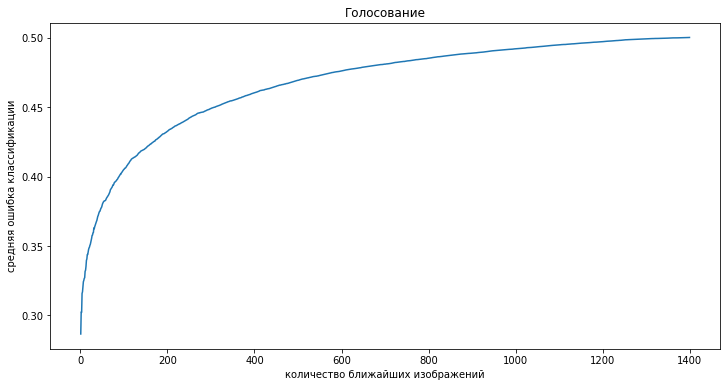

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x, y)
plt.xlabel('количество ближайших изображений')
plt.ylabel('средняя ошибка классификации')
plt.title('Голосование')
plt.show()

In [44]:
y.min()

0.2866666666666666

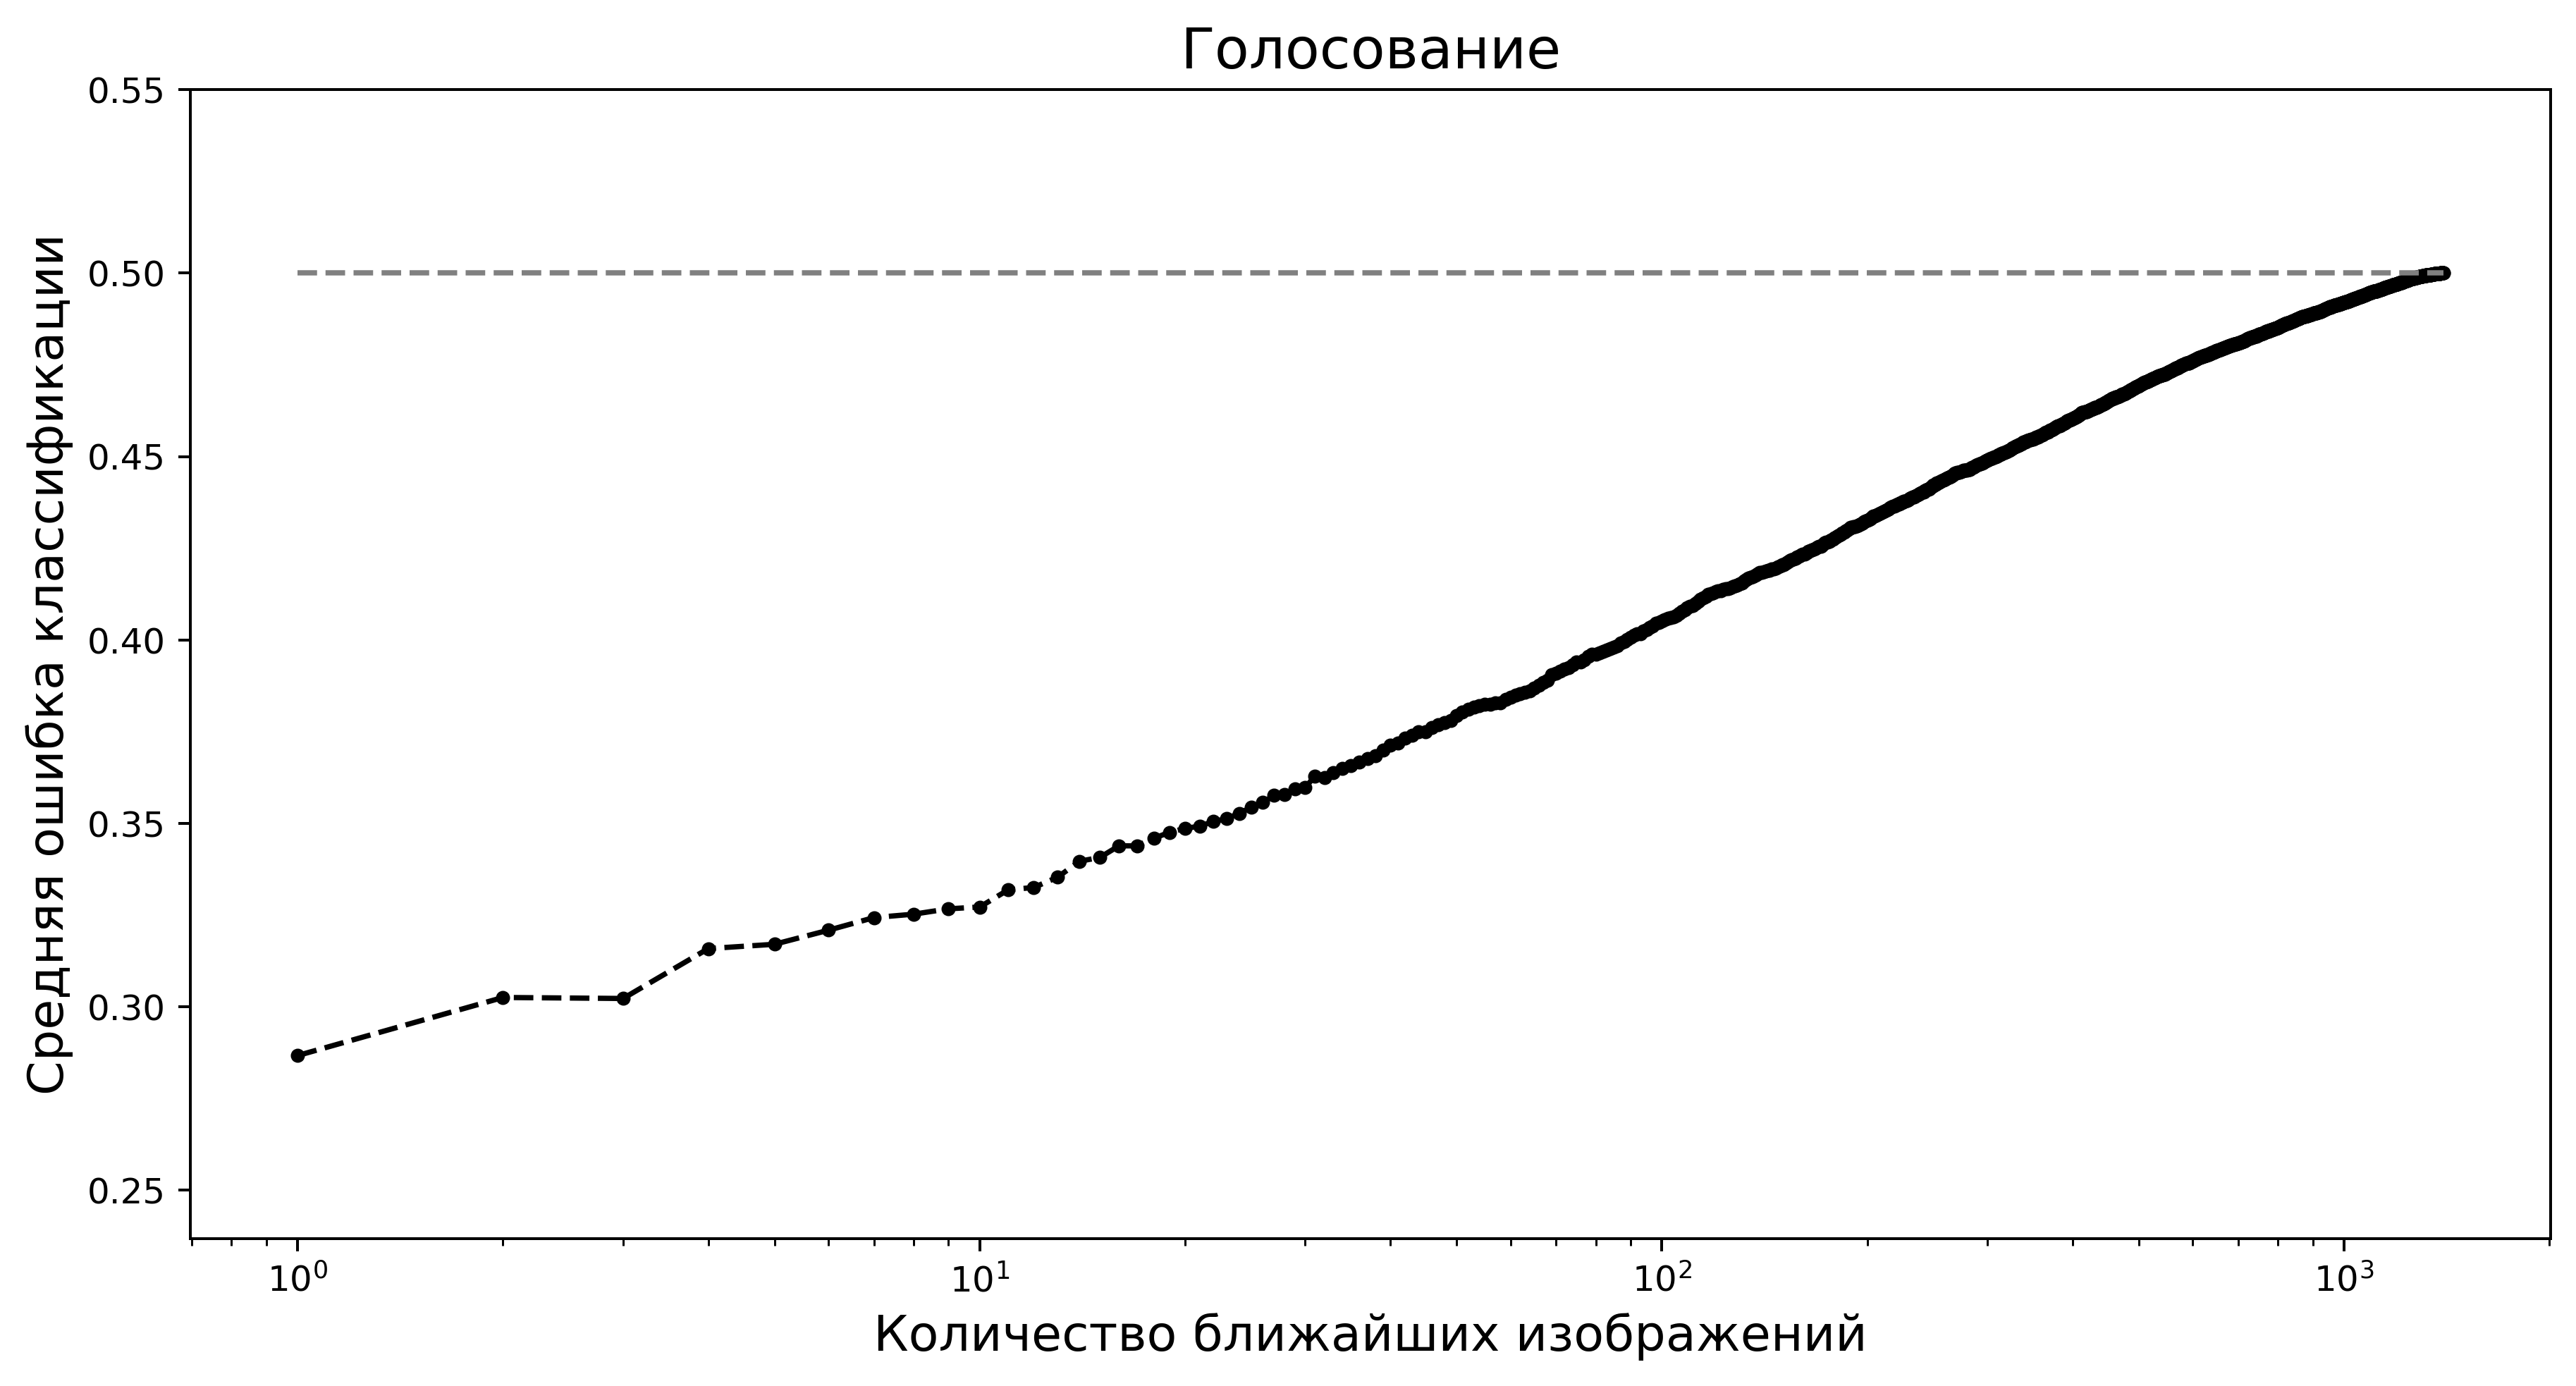

In [45]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=360)
ax.set_xscale('log')
plt.plot(x, y, linestyle="--", marker=".", color="black")
plt.hlines(0.5, np.min(x), np.max(x), linestyle="--", color='gray')
plt.ylim([y.min() - 0.05, y.max() + 0.05])
#plt.xlim([0, 100])
plt.xlabel('Количество ближайших изображений', fontsize=14)
plt.ylabel('Средняя ошибка классификации', fontsize=14)
plt.title('Голосование', fontsize=16)
plt.savefig('Voting_1_Harr.png', bbox_inches='tight')
plt.show()

In [46]:
optimal_N = np.argmin(y) + 1
print("оптимальный размер ближайших изображений:", optimal_N,
      "\nоценка ошибки (accuracy):", y[optimal_N])

оптимальный размер ближайших изображений: 1 
оценка ошибки (accuracy): 0.3025


In [53]:
# Преобразуем RGB картинку в серый цвет
# Создается вектор из кортежей (номер изображения, название объекта, бинарный вектор-признак изображения)
# Для поискового датасета
search_N = len(search_imgs)
search_imgs_gray = []

for i in range(search_N):
    search_imgs_gray.append((search_imgs_tuple[i][0], search_imgs_tuple[i][1], RGB2GRAY(search_imgs_tuple[i][2])))

# тестового датасета
test_N = len(test_imgs)
test_imgs_gray = []
for i in range(test_N):
    test_imgs_gray.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1], RGB2GRAY(test_imgs_tuple[i][2])))

# Преобразуем матрицу в вектор
# Для поискового датасета
search_N = len(search_imgs)
search_imgs_vec = []
numpy2vec_method = "diag"

for i in range(search_N):
    search_imgs_vec.append((search_imgs_gray[i][0], search_imgs_gray[i][1],
                            numpy2vec(search_imgs_gray[i][2], method=numpy2vec_method)))

# Для тестового датасета
test_N = len(test_imgs)
test_imgs_vec = []

for i in range(test_N):
    test_imgs_vec.append((test_imgs_gray[i][0], test_imgs_gray[i][1],
                          numpy2vec(test_imgs_gray[i][2], method=numpy2vec_method)))

def collect_data_for_graph(max_depth):
    # Преобразуем десятичный вектор в двоичный
    # Для поискового датасета
    start_time = time.time()
    search_N = len(search_imgs)
    search_imgs_bin = []

    for i in range(search_N):
        search_imgs_bin.append((search_imgs_vec[i][0], search_imgs_vec[i][1],
                                dec2bin(search_imgs_vec[i][2], method=dec2bin_method, max_depth=max_depth)))

    # Для тестового датасета
    test_N = len(test_imgs)
    test_imgs_bin = []

    for i in range(test_N):
        test_imgs_bin.append((test_imgs_tuple[i][0], test_imgs_tuple[i][1],
                              dec2bin(test_imgs_vec[i][2], method=dec2bin_method, max_depth=max_depth)))

    # Находим расстояния по Хэмминге
    # номер, класс т, номер, класс п, расстояние
    # Создаем tuple_imgs вектор из кортежей (номер изображения, название объекта, бинарный вектор-признак изображения)
    hamming_distance_matrix = []
    #distance_method="my_norm_hamming"
    for i in range(test_N):
        hamming_distance_list = []
        for j in range(search_N):
            hamming_distance_list.append((test_imgs_bin[i][0], test_imgs_bin[i][1],
                                          search_imgs_bin[j][0], search_imgs_bin[j][1],
                                          distance(test_imgs_bin[i][2], search_imgs_bin[j][2], method=distance_method)))
        hamming_distance_matrix.append(hamming_distance_list)
    
    sorted_h_distance = sort_distance(hamming_distance_matrix)

    graph = []
    n = 600
    m = 1400
    for i in range(n):
        one_line = []
        for j in range(m):
            one_line.append(class_by_matrix(sorted_h_distance[i][j]))
        graph.append(one_line)
    
    dist_mean = pd.DataFrame(graph).mean()
    print("--- %s seconds ---" % (time.time() - start_time))
    return dist_mean[:1].mean()

In [24]:
max_depthes = [1, 3, 5, 7, 9, 11, 13, 15, 17]
y = []
for max_depth in max_depthes:
    y.append(collect_data_for_graph(max_depth))


NameError: name 'collect_data_for_graph' is not defined

In [7]:
collect_data_for_graph(13)

NameError: name 'collect_data_for_graph' is not defined

In [28]:
y = 1 - np.array(y)
n = len(y)
x = [i for i in max_depthes][:len(y)]
y

array([0.50388889, 0.47777778, 0.435     , 0.38888889, 0.34222222,
       0.30222222, 0.28944444, 0.31833333, 0.31833333])

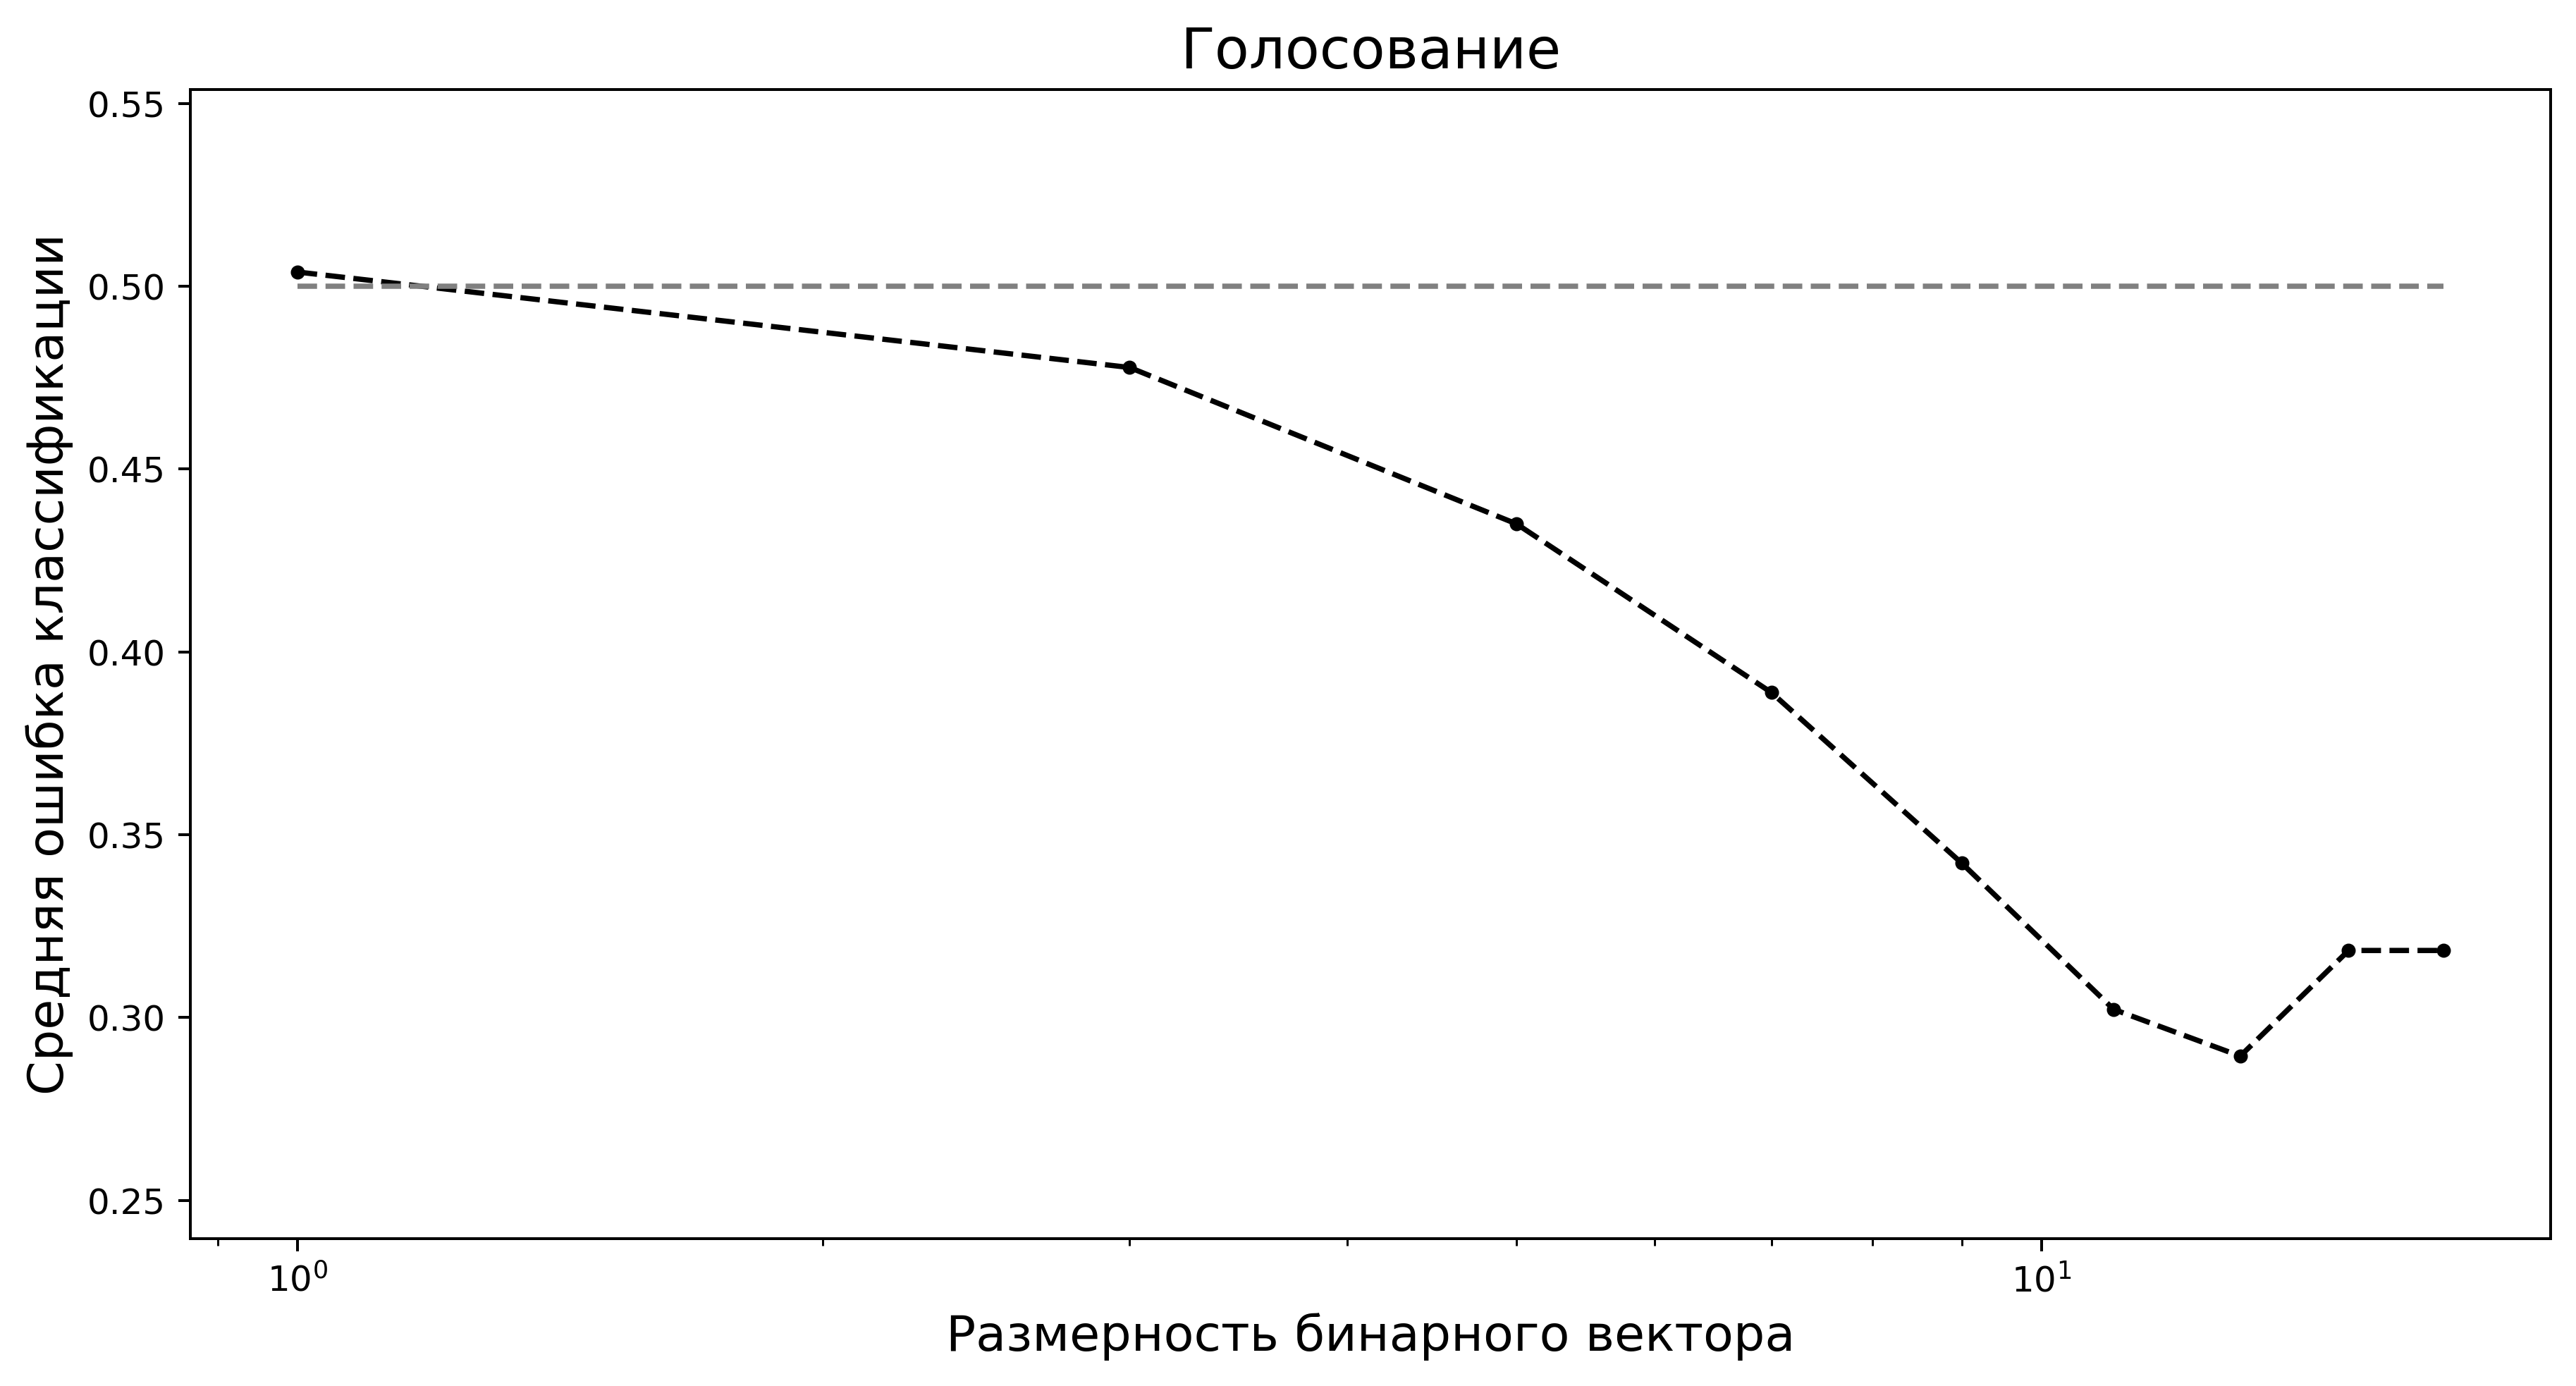

In [29]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=360)
ax.set_xscale('log')
plt.plot(x, y, linestyle="--", marker=".", color="black")
plt.hlines(0.5, np.min(x), np.max(x), linestyle="--", color='gray')
plt.ylim([y.min() - 0.05, y.max() + 0.05])
#plt.xlim([0, 100])
plt.xlabel('Размерность бинарного вектора', fontsize=14)
plt.ylabel('Средняя ошибка классификации', fontsize=14)
plt.title('Голосование', fontsize=16)
plt.savefig('Voting_2_Harr.png', bbox_inches='tight')
plt.show()

In [23]:
optimal_N = np.argmin(y)
print("оптимальный размер ближайших изображений:", max_depthes[optimal_N],
      "\nоценка ошибки (accuracy):", y[optimal_N])

оптимальный размер ближайших изображений: 13 
оценка ошибки (accuracy): 0.28944444


In [25]:
y = [0.50388889, 0.47777778, 0.435, 0.38888889, 0.34222222, 0.30222222, 0.28944444, 0.31833333, 0.31833333]
#y = [0.50166667, 0.46111111, 0.42666667, 0.38388889, 0.345, 0.30222222, 0.26333333, 0.29166667, 0.29166667]